In [4]:
# image lib
from PIL import Image, ImageDraw

# file/directory lib
import os
import shutil

# numerical lib
import pandas as pd
from pandas import DataFrame

#visualization lib
from IPython import display
from tqdm.notebook import tqdm

#python lib
import json

## Converting data into yolov5 format and file directory
EXAMPLE: \
yolov5 will change the directory from images to labels and change the extension \
dataset/images/im0.jpg  # image
dataset/labels/im0.txt  # label

- COTS
 - images 
     - train 
     - val 
 - labels 
     - train 
     - val 
     
According to https://docs.ultralytics.com/tutorials/train-custom-datasets/, below is the format for the labels. txt file

One row per object \
Each row is class x_center y_center width height format. \
Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height. \
Class numbers are zero-indexed (start from 0).

## Using previously split strategy during preparation of tfrecords

In [10]:
full_df = pd.read_csv("data/raw_data/train_df.csv")
full_df.head()

,Unnamed: 0,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_cots_det,filepath,is_cot_detected,group_number,k_fold
0,0,0,40258,0,0,0-0,[],0,../input/tensorflow-great-barrier-reef/train_i...,0,0,4
1,1,0,40258,1,1,0-1,[],0,../input/tensorflow-great-barrier-reef/train_i...,0,0,4
2,2,0,40258,2,2,0-2,[],0,../input/tensorflow-great-barrier-reef/train_i...,0,0,4
3,3,0,40258,3,3,0-3,[],0,../input/tensorflow-great-barrier-reef/train_i...,0,0,4
4,4,0,40258,4,4,0-4,[],0,../input/tensorflow-great-barrier-reef/train_i...,0,0,4


In [14]:
full_df['filepath'] = full_df['filepath'].str.replace("../input/tensorflow-great-barrier-reef/train_images", "data/raw_data", regex=True)

In [15]:
full_df.iloc[0]['filepath']

'data/raw_data/video_0/0.jpg'

In [16]:
train_df = full_df[full_df['k_fold']!=0]
val_df = full_df[full_df['k_fold']==0]

print("Train_df size: ", len(train_df))
print("Val_df size: ", len(val_df))

Train_df size:  18702
Val_df size:  4799


## Creating the file directory
1. create COTS directory
2. create images directory
3. create labels directory
4. for images and labels directory create train and val directory

In [17]:
COTS_DIR = "data/COTS"
IMAGE_DIR = os.path.join(COTS_DIR, "images")
LABEL_DIR = os.path.join(COTS_DIR, "labels")
#sub-directories
TRAIN_IMAGE_DIR = os.path.join(IMAGE_DIR,"train")
TRAIN_LABEL_DIR = os.path.join(LABEL_DIR,"train")
VAL_IMAGE_DIR = os.path.join(IMAGE_DIR,"val")
VAL_LABEL_DIR = os.path.join(LABEL_DIR,"val")

os.makedirs(COTS_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(LABEL_DIR, exist_ok = True)

# create sub directories for images and labels folder
for subdir in ['train', 'val']:
    os.makedirs(os.path.join(IMAGE_DIR,subdir), exist_ok=True)
    os.makedirs(os.path.join(LABEL_DIR,subdir), exist_ok = True)

In [18]:
def convert_single_image(source_image_fp:str, annotations:list, dest_image_name:str, 
                        dest_image_dir:str, dest_label_dir:str , debug:bool =False):    
    ## copy image over to dest_image folder
    shutil.copyfile(source_image_fp, os.path.join(dest_image_dir, dest_image_name+'.jpg'))

    ## create label file and save to label folder
    class_id = '0'
    records = []
    
    # Open image to get image size
    pil_image = Image.open(source_image_fp)
    
    annotations = json.loads(annotations.replace("'",'"'))
    for ann in annotations:
        record = "{} {} {} {} {}\n".format(
            class_id,
            (ann['x']+ann['width']/2)/pil_image.width,
            (ann['y']+ann['height']/2)/pil_image.height,
            ann['width']/pil_image.width,
            ann['height']/pil_image.height
        )
        records.append(record)
    
    label_filepath = os.path.join(dest_label_dir, dest_image_name+'.txt')
    with open(label_filepath, 'w') as labelfile:
        labelfile.writelines(records)
    
    if debug:
        draw = ImageDraw.Draw(pil_image)
        draw.text(((ann['x']+ann['width']/2), (ann['y']+ann['height']/2)),
                  text='FOUND', stroke_width=3, fill='red', align='center')
        display.display(pil_image)            
                
def convert_df(df:DataFrame, dest_image_dir:str, dest_label_dir:str):
    dataframe_length = len(df)
    
    for i in tqdm(range(dataframe_length)):
        row = df.iloc[i]
        dest_image_name = str(row["video_id"])+"_"+str(row["video_frame"])
        
        convert_single_image(row['filepath'], row['annotations'], dest_image_name, 
                            dest_image_dir, dest_label_dir)
    

row: Unnamed: 0                                                        30
video_id                                                           0
sequence                                                       40258
video_frame                                                       30
sequence_frame                                                    30
image_id                                                        0-30
annotations        [{'x': 518, 'y': 176, 'width': 69, 'height': 54}]
n_cots_det                                                         1
filepath                                data/raw_data/video_0/30.jpg
is_cot_detected                                                    1
group_number                                                       0
k_fold                                                             4
Name: 30, dtype: object
dest_image_name:  0_30


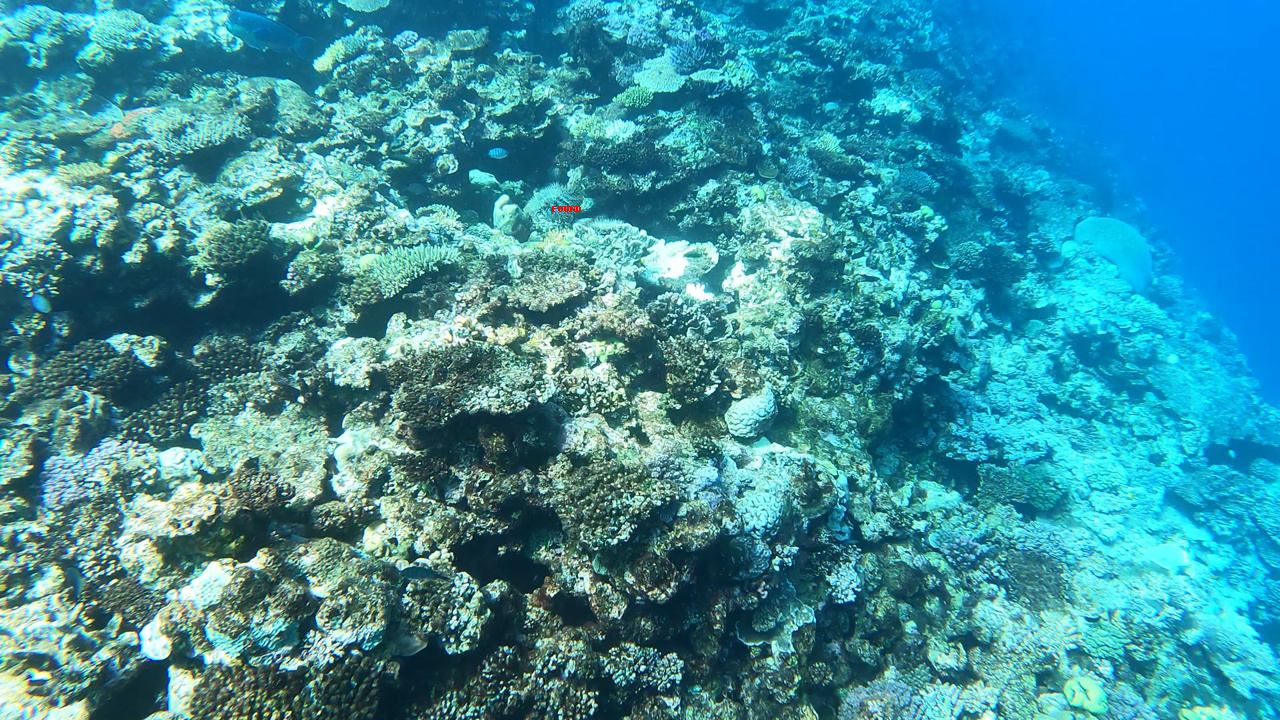

In [19]:
## Testing
row = train_df.iloc[30]
print("row:" ,row)

dest_image_name = str(row["video_id"])+"_"+str(row["video_frame"])
print("dest_image_name: ", dest_image_name)

convert_single_image(row['filepath'], row['annotations'], dest_image_name, 
               TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, debug=True)

In [20]:
# Converting training data
convert_df(train_df, TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)

  0%|          | 0/18702 [00:00<?, ?it/s]

In [21]:
# Converting validation data
convert_df(val_df, VAL_IMAGE_DIR, VAL_LABEL_DIR)

  0%|          | 0/4799 [00:00<?, ?it/s]

## Zipping and exporting

In [ ]:
!zip -r data/COTS.zip data/COTS